In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tqdm import tqdm,trange

In [5]:
from google.colab import drive
drive.mount('/content/drive')
dirpath='/content/drive/MyDrive/HW3/stanford_dogs/'

Mounted at /content/drive


In [6]:
imgSize = (224,224)
imgShape = (224,224,3)
batchSize = 64

In [7]:
trainDataGenerator = ImageDataGenerator(rescale = 1./255,
                      # augmentation
                      rotation_range = 40,
                      shear_range = 0.3,
                      #zoom_range = 0.2,
                      horizontal_flip=True,
                      #vertical_flip=True,
                      validation_split=0.3)
valDataGenerator = ImageDataGenerator(rescale=1./255,validation_split=0.3)


trainBatch = trainDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='training'
)

valBatch = valDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='validation'
)

# test generator
testDataGenerator = ImageDataGenerator(rescale=1/255)

testBatch = testDataGenerator.flow_from_directory(
    dirpath,
    class_mode=None,
    batch_size=batchSize,
    target_size= imgSize,
    shuffle = False,
    classes=['test']
)


Found 8400 images belonging to 120 classes.
Found 3600 images belonging to 120 classes.
Found 8580 images belonging to 1 classes.


In [8]:
from tensorflow.keras.applications import InceptionResNetV2, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, concatenate, Input
from tensorflow.keras.models import Model

In [9]:
base_model1 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
)
base_model2 = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
)
base_model3 = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    include_preprocessing=False

)
base_model4 = tf.keras.applications.NASNetLarge(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),

)
base_model5 = tf.keras.applications.ConvNeXtLarge(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    include_preprocessing=False

)

input1 = Input(shape=(224, 224, 3), name='input_1')

inception_resnet_output = GlobalAveragePooling2D()(base_model1(input1))
xception_output = GlobalAveragePooling2D()(base_model2(input1))
EfficientNetV2M_output = GlobalAveragePooling2D()(base_model3(input1))
NASNetLarge_output = GlobalAveragePooling2D()(base_model4(input1))
ConvNeXtLarge_output = GlobalAveragePooling2D()(base_model5(input1))

merged = concatenate([inception_resnet_output, xception_output, EfficientNetV2M_output, NASNetLarge_output, ConvNeXtLarge_output])
x = layers.BatchNormalization()(merged)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
output_layer = layers.Dense(units = 120, activation = 'softmax')(x)
# freeze the weight
base_model1.trainable = False
base_model2.trainable = False
base_model3.trainable = False
base_model4.trainable = False
base_model5.trainable = False

combined_model = Model(inputs= input1, outputs=output_layer)

785596384/785596384 [==============================] - 27s 0us/step


In [10]:
print(input1.shape)

(None, 224, 224, 3)


In [11]:
from keras.models import Sequential
from keras.layers import Input, BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionResNetV2, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, concatenate
from tensorflow.keras.models import Model
# Define input layer
input1 = Input(shape=(224, 224, 3), name='input_1')

# Create the first base model
x1 = base_model1(input1)
x1 = GlobalAveragePooling2D()(x1)

# Create the second base model
x2 = base_model2(input1)
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3(input1)
x3 = GlobalAveragePooling2D()(x3)

x4 = base_model4(input1)
x4 = GlobalAveragePooling2D()(x4)

x5 = base_model5(input1)
x5 = GlobalAveragePooling2D()(x5)

concatenated = concatenate([x1, x2, x3, x4, x5])

x = BatchNormalization()(concatenated)

x = Dense(1024, activation='relu')(x)

x = Dropout(0.5)(x)

x = BatchNormalization()(x)

output_layer = Dense(units=120, activation='softmax')(x)

sequential_model = Model(input1, outputs=output_layer)

sequential_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)           5433673   ['input_1[0][0]']             
 ional)                                                   6                                       
                                                                                                  
 xception (Functional)       (None, 7, 7, 2048)           2086148   ['input_1[0][0]']             
                                                          0                                       
                                                                                            

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math

def lr_decay(epoch):
    initial_lr = 0.01
    decay_factor = 0.1
    decay_epochs = 6
    lrate = initial_lr * math.pow(decay_factor, math.floor((1 + epoch) / decay_epochs))
    return lrate
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8)

lr_scheduler = LearningRateScheduler(lr_decay)

combined_model.compile(optimizer = Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer = Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/HW3/model_concat5.h5", verbose=1, save_best_only=True)

In [ ]:
print(combined_model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:
import numpy as np
epoch=50





history = combined_model.fit(
   trainBatch,
    steps_per_epoch=trainBatch.samples // batchSize,
    validation_data=valBatch,
    validation_steps=valBatch.samples // batchSize,
    epochs=epoch,
    callbacks=[early_stopping, lr_scheduler, checkpointer]
)

Epoch 1/50


2023-11-30 08:26:29.983442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


131/131 [==============================] - ETA: 0s - loss: 1.1869 - accuracy: 0.7790
Epoch 1: val_loss improved from inf to 0.57120, saving model to /kaggle/working/model_concat5.h5
131/131 [==============================] - 549s 3s/step - loss: 1.1869 - accuracy: 0.7790 - val_loss: 0.5712 - val_accuracy: 0.8870 - lr: 0.0100
Epoch 2/50
131/131 [==============================] - ETA: 0s - loss: 0.8330 - accuracy: 0.8534
Epoch 2: val_loss improved from 0.57120 to 0.55243, saving model to /kaggle/working/model_concat5.h5
131/131 [==============================] - 416s 3s/step - loss: 0.8330 - accuracy: 0.8534 - val_loss: 0.5524 - val_accuracy: 0.9007 - lr: 0.0100
Epoch 3/50
131/131 [==============================] - ETA: 0s - loss: 0.6267 - accuracy: 0.8767
Epoch 3: val_loss did not improve from 0.55243
131/131 [==============================] - 408s 3s/step - loss: 0.6267 - accuracy: 0.8767 - val_loss: 0.5593 - val_accuracy: 0.9076 - lr: 0.0100
Epoch 4/50
131/131 [=======================

show the loss & accuracy curve

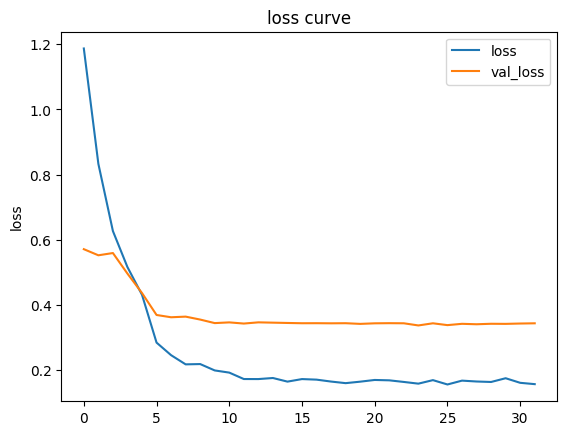

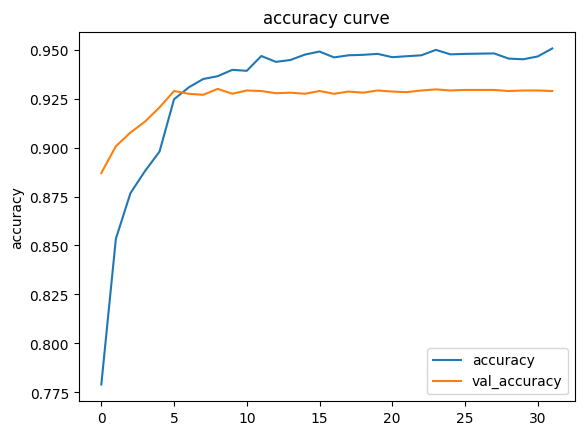

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

predict test data

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
prediction = combined_model.predict(testBatch)
prediction

135/135 [==============================] - 319s 2s/step


array([[2.24360683e-05, 2.33559124e-03, 1.01785258e-06, ...,
        1.82055237e-06, 9.96828167e-05, 2.81814573e-06],
       [9.59016894e-11, 1.00000000e+00, 2.95371236e-12, ...,
        5.97140718e-13, 1.01005496e-10, 3.61966984e-11],
       [2.07983941e-09, 9.98499061e-09, 5.82120574e-09, ...,
        3.04126641e-10, 2.51667776e-09, 8.10673839e-09],
       ...,
       [2.22017582e-09, 1.20271001e-10, 2.54937849e-10, ...,
        5.89072080e-09, 3.46986528e-09, 1.15829195e-08],
       [5.09524298e-11, 4.66713057e-11, 2.84921475e-10, ...,
        1.46467283e-11, 7.38568859e-11, 8.37055078e-11],
       [7.08976611e-09, 9.12174727e-08, 2.27999095e-08, ...,
        1.53748658e-09, 9.44188017e-09, 1.93712367e-07]], dtype=float32)

In [ ]:
prediction_label=prediction.argmax(axis=1)
filename=testBatch.filenames
outputdf=pd.DataFrame()
outputdf['Name']=filename
outputdf['Label']=prediction_label
outputdf.to_csv('/content/drive/MyDrive/HW3/prediction_concat5.csv',index=False)